In [60]:
import pandas as pd
import numpy as np
import random
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import load_model

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [61]:
def prepareData(dir_train, dir_test):
    data_train = pd.read_csv(dir_train)
    data_test = pd.read_csv(dir_test)

    X_train = data_train.drop(['Activity', 'Activity_code'], axis=1)
    y_train = data_train['Activity_code']

    X_test = data_test.drop(['Activity', 'Activity_code'], axis=1)
    y_test = data_test['Activity_code']

    return X_train, X_test, y_train, y_test

In [62]:
dir_train = "../../data/interim/trainFinal.csv"
dir_test = "../../data/interim/testFinal.csv"
X_train, X_test, y_train, y_test = prepareData(dir_train, dir_test)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_train= X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [63]:
import os

def save_model(model, history, base_dir_model, bar_dir_history, model_name, sub_model_name=""):

    # Tạo thư mục chính nếu chưa tồn tại
    if not os.path.exists(base_dir_model):
        os.makedirs(base_dir_model)
    if not os.path.exists(bar_dir_history):
        os.makedirs(bar_dir_history)
  
    model_file = os.path.join(base_dir_model, f"model_{model_name}_{sub_model_name}.h5")
    history_file = os.path.join(bar_dir_history, f"history_{model_name}_{sub_model_name}.pkl")
    
    # Lưu model
    model.save(model_file)
    print(f"Model saved to: {model_file}")
    
    # Lưu lịch sử huấn luyện
    with open(history_file, "wb") as f:
        pickle.dump(history.history, f)
    print(f"Model history saved to: {history_file}")



In [64]:
def load_model_and_history(model_path, history_path):
    """
    Args:
        model_path (str): Đường dẫn đến file mô hình (.h5).
        history_path (str): Đường dẫn đến file lịch sử huấn luyện (.pkl).
    """

    model = load_model(model_path)
    print(f"Model loaded from: {model_path}")

    # Tải lịch sử huấn luyện
    with open(history_path, "rb") as f:
        history = pickle.load(f)
    print(f"Model history loaded from: {history_path}")

    return model, history

## Experiment 1: 

In [65]:
def build_lstm_model(input_shape, output_shape, number_LayerLSTM):
    model = Sequential()
    for i in range(number_LayerLSTM):
        model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

def train_lstm_model(X_train, Y_train, X_val, Y_val, number_LayerLSTM, batch_size=32, epochs=10):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(Y_train)),number_LayerLSTM)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    return model, history

In [66]:
# Train LSTM model
epochs = 50
number_LayerLSTM_List = [1, 2, 3, 4]
model_list_1 = []
model_history_list_1 = []
base_dir_model = "Experiment_Tracking_LSTM/models"
bar_dir_history = "Experiment_Tracking_LSTM/history_models"

for number_LayerLSTM in number_LayerLSTM_List:
    model, history = train_lstm_model(X_train, y_train, X_test, y_test, epochs=epochs, number_LayerLSTM=number_LayerLSTM)
    model_list_1.append(model)
    model_history_list_1.append(history)
    model_name = "Exp1_LSTM"
    sub_model_name = f"num_Layers_{number_LayerLSTM}"
    save_model(model, history, base_dir_model, bar_dir_history, model_name, sub_model_name)
    

Epoch 1/50
230/230 [==============================] - 4s 9ms/step - loss: 0.4856 - accuracy: 0.8192 - val_loss: 0.3039 - val_accuracy: 0.8554
Epoch 2/50
230/230 [==============================] - 2s 7ms/step - loss: 0.1748 - accuracy: 0.9338 - val_loss: 0.2501 - val_accuracy: 0.8938
Epoch 3/50
230/230 [==============================] - 1s 6ms/step - loss: 0.1372 - accuracy: 0.9472 - val_loss: 0.1527 - val_accuracy: 0.9382
Epoch 4/50
230/230 [==============================] - 1s 6ms/step - loss: 0.1088 - accuracy: 0.9597 - val_loss: 0.1676 - val_accuracy: 0.9365
Epoch 5/50
230/230 [==============================] - 1s 5ms/step - loss: 0.0988 - accuracy: 0.9604 - val_loss: 0.1473 - val_accuracy: 0.9416
Epoch 6/50
230/230 [==============================] - 1s 5ms/step - loss: 0.0948 - accuracy: 0.9615 - val_loss: 0.2013 - val_accuracy: 0.9281
Epoch 7/50
230/230 [==============================] - 1s 5ms/step - loss: 0.0834 - accuracy: 0.9695 - val_loss: 0.1583 - val_accuracy: 0.9433
Epoch 

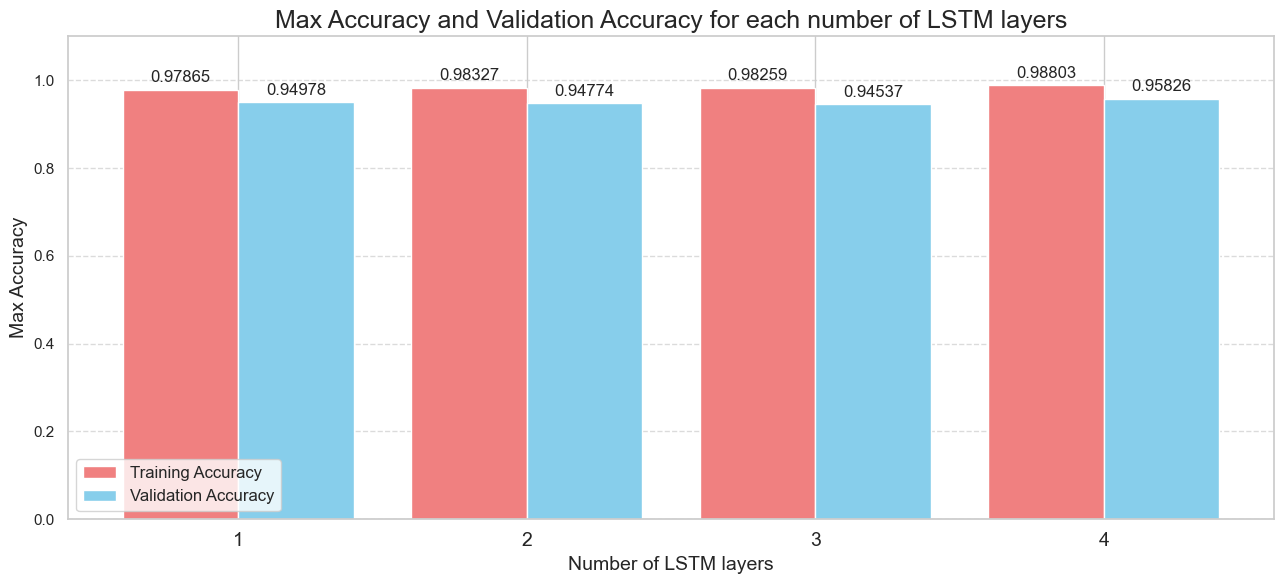

In [67]:
max_accuracies_1 = []
max_val_accuracies_1 = []

for history in model_history_list_1:
    # Lấy giá trị lớn nhất của accuracy và val_accuracy
    max_accuracy = max(history.history['accuracy'])
    max_val_accuracy = max(history.history['val_accuracy'])
    max_accuracies_1.append(max_accuracy)
    max_val_accuracies_1.append(max_val_accuracy)

sns.set(style="whitegrid")

# Vẽ biểu đồ
x_labels = [str(n) for n in number_LayerLSTM_List]  # Chuyển số lượng layer thành chuỗi để hiển thị
x_indices = np.arange(len(x_labels))  # Tạo vị trí cho các cột

width = 0.4  # Độ rộng của mỗi cột
plt.figure(figsize=(13, 6))

# Cột accuracy
plt.bar(x_indices - width/2, max_accuracies_1, width=width, label="Training Accuracy", color='lightcoral')

# Cột val_accuracy
plt.bar(x_indices + width/2, max_val_accuracies_1, width=width, label="Validation Accuracy", color='skyblue')

# Thiết lập trục X
plt.xticks(x_indices, x_labels, fontsize=14)
plt.title("Max Accuracy and Validation Accuracy for each number of LSTM layers", fontsize=18)
plt.xlabel("Number of LSTM layers", fontsize=14)
plt.ylabel("Max Accuracy", fontsize=14)
plt.ylim(0, 1.1)  # Giới hạn trục y nếu cần
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên các cột
for i, (x, acc, val_acc) in enumerate(zip(x_indices, max_accuracies_1, max_val_accuracies_1)):
    plt.text(x - width/2, acc + 0.01, f"{acc:.5f}", ha='center', va='bottom', fontsize=12)
    plt.text(x + width/2, val_acc + 0.01, f"{val_acc:.5f}", ha='center', va='bottom', fontsize=12)

# Hiển thị chú thích
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Nhận xét:
- Validation Accuracy cao nhất khi sử dụng 2 LSTM layers

## Experiment 2: Test number of units in LSTM layer

In [68]:
def build_lstm_model(input_shape, output_shape, number_UnitsLSTM):
    model = Sequential()
    model.add(LSTM(number_UnitsLSTM, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(number_UnitsLSTM, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Dense(number_UnitsLSTM, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

def train_lstm_model(X_train, Y_train, X_val, Y_val, number_UnitsLSTM, batch_size=32, epochs=10):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(Y_train)),number_UnitsLSTM)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    return model, history

In [69]:
# Train LSTM model
epochs = 50
number_UnitsLSTM_List = [32, 64, 128, 256]
model_list_2 = []
model_history_list_2 = []
base_dir_model = "Experiment_Tracking_LSTM/models"
bar_dir_history = "Experiment_Tracking_LSTM/history_models"

for number_UnitsLSTM in number_UnitsLSTM_List:
    model, history = train_lstm_model(X_train, y_train, X_test, y_test, epochs=epochs, number_UnitsLSTM=number_UnitsLSTM)
    model_list_2.append(model)
    model_history_list_2.append(history)
    model_name = "Exp2_LSTM"
    sub_model_name = f"number_Units_{number_UnitsLSTM}"
    save_model(model, history, base_dir_model, bar_dir_history, model_name, sub_model_name)



Epoch 1/50
230/230 [==============================] - 6s 9ms/step - loss: 0.9302 - accuracy: 0.6055 - val_loss: 0.4073 - val_accuracy: 0.8415
Epoch 2/50
230/230 [==============================] - 1s 5ms/step - loss: 0.2904 - accuracy: 0.8629 - val_loss: 0.3287 - val_accuracy: 0.8887
Epoch 3/50
230/230 [==============================] - 1s 5ms/step - loss: 0.1766 - accuracy: 0.9306 - val_loss: 0.2545 - val_accuracy: 0.9050
Epoch 4/50
230/230 [==============================] - 1s 5ms/step - loss: 0.1276 - accuracy: 0.9517 - val_loss: 0.2456 - val_accuracy: 0.9172
Epoch 5/50
230/230 [==============================] - 1s 5ms/step - loss: 0.1042 - accuracy: 0.9601 - val_loss: 0.1659 - val_accuracy: 0.9416
Epoch 6/50
230/230 [==============================] - 1s 6ms/step - loss: 0.0873 - accuracy: 0.9672 - val_loss: 0.5109 - val_accuracy: 0.8649
Epoch 7/50
230/230 [==============================] - 1s 5ms/step - loss: 0.0828 - accuracy: 0.9720 - val_loss: 0.1733 - val_accuracy: 0.9420
Epoch 

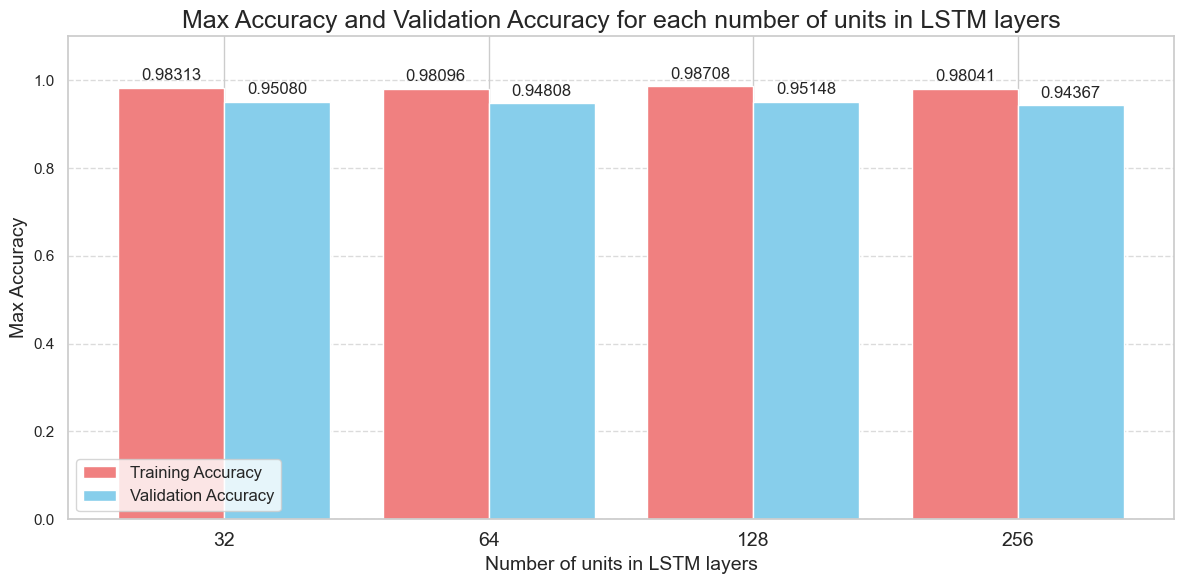

In [70]:
max_accuracies_2 = []
max_val_accuracies_2 = []

for history in model_history_list_2:
    # Lấy giá trị lớn nhất của accuracy và val_accuracy
    max_accuracy = max(history.history['accuracy'])
    max_val_accuracy = max(history.history['val_accuracy'])
    max_accuracies_2.append(max_accuracy)
    max_val_accuracies_2.append(max_val_accuracy)

sns.set(style="whitegrid")

# Vẽ biểu đồ
x_labels = [str(n) for n in number_UnitsLSTM_List]  # Chuyển số lượng layer thành chuỗi để hiển thị
x_indices = np.arange(len(x_labels))  # Tạo vị trí cho các cột

width = 0.4  # Độ rộng của mỗi cột
plt.figure(figsize=(12, 6))

# Cột accuracy
plt.bar(x_indices - width/2, max_accuracies_2, width=width, label="Training Accuracy", color='lightcoral')

# Cột val_accuracy
plt.bar(x_indices + width/2, max_val_accuracies_2, width=width, label="Validation Accuracy", color='skyblue')

# Thiết lập trục X
plt.xticks(x_indices, x_labels, fontsize=14)
plt.title("Max Accuracy and Validation Accuracy for each number of units in LSTM layers", fontsize=18)
plt.xlabel("Number of units in LSTM layers", fontsize=14)
plt.ylabel("Max Accuracy", fontsize=14)
plt.ylim(0, 1.1)  # Giới hạn trục y nếu cần
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên các cột
for i, (x, acc, val_acc) in enumerate(zip(x_indices, max_accuracies_2, max_val_accuracies_2)):
    plt.text(x - width/2, acc + 0.01, f"{acc:.5f}", ha='center', va='bottom', fontsize=12)
    plt.text(x + width/2, val_acc + 0.01, f"{val_acc:.5f}", ha='center', va='bottom', fontsize=12)

# Hiển thị chú thích
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Nhận xét:

## Experiment 3: Test using Bidirectional LSTM

In [71]:
def build_lstm_model(input_shape, output_shape):
    model = Sequential()
    # Thêm Bidirectional vào lớp LSTM thứ nhất
    model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape))

    # Thêm Bidirectional vào lớp LSTM thứ hai
    model.add(Bidirectional(LSTM(256)))
    
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

def train_lstm_model(X_train, Y_train, X_val, Y_val, batch_size=32, epochs=10):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), len(np.unique(Y_train)))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)
    return model, history



Epoch 1/50
230/230 [==============================] - 31s 116ms/step - loss: 0.3768 - accuracy: 0.8380 - val_loss: 0.4230 - val_accuracy: 0.8171
Epoch 2/50
230/230 [==============================] - 21s 93ms/step - loss: 0.1448 - accuracy: 0.9448 - val_loss: 0.2534 - val_accuracy: 0.9121
Epoch 3/50
230/230 [==============================] - 22s 97ms/step - loss: 0.1032 - accuracy: 0.9582 - val_loss: 0.3075 - val_accuracy: 0.9036
Epoch 4/50
230/230 [==============================] - 22s 96ms/step - loss: 0.1102 - accuracy: 0.9572 - val_loss: 0.2056 - val_accuracy: 0.9332
Epoch 5/50
230/230 [==============================] - 24s 102ms/step - loss: 0.0838 - accuracy: 0.9674 - val_loss: 0.2052 - val_accuracy: 0.9406
Epoch 6/50
230/230 [==============================] - 23s 99ms/step - loss: 0.0778 - accuracy: 0.9698 - val_loss: 0.3182 - val_accuracy: 0.9104
Epoch 7/50
230/230 [==============================] - 22s 96ms/step - loss: 0.0741 - accuracy: 0.9709 - val_loss: 0.1974 - val_accurac

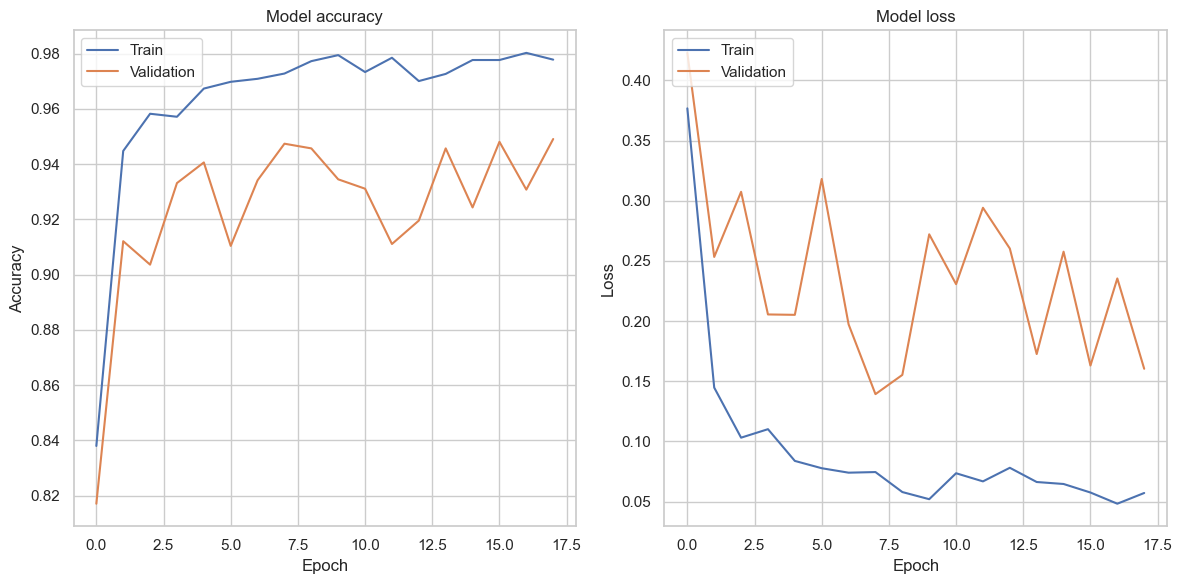

In [72]:
# X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Train LSTM model
epochs = 50
lstm_model, lstm_history = train_lstm_model(X_train, y_train, X_test, y_test, epochs = epochs)

# Plot training and validation curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [73]:
lstm_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 1, 512)           1675264   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 512)               0         
                                                                 
 dense_56 (Dense)            (None, 64)                32832     
                                                                 
 dense_57 (Dense)            (None, 6)                 390       
                                                                 
Total params: 3,283,398
Trainable params: 3,283,398
N

In [74]:
print("Training Accuracy: ", max(lstm_history.history['accuracy']))
print("Validation Accuracy: ", max(lstm_history.history['val_accuracy']))

Training Accuracy:  0.9802774786949158
Validation Accuracy:  0.9491007924079895


In [75]:
base_dir_model = "Experiment_Tracking_LSTM/models"
bar_dir_history = "Experiment_Tracking_LSTM/history_models"
model_name = "Exp3_LSTM"
sub_model_name = "Bidirectional"
save_model(lstm_model, lstm_history, base_dir_model, bar_dir_history, model_name, sub_model_name)

Model saved to: Experiment_Tracking_LSTM/models\model_Exp3_LSTM_Bidirectional.h5
Model history saved to: Experiment_Tracking_LSTM/history_models\history_Exp3_LSTM_Bidirectional.pkl


In [76]:
# from sklearn.metrics import precision_score, recall_score, f1_score
# 
# def evaluate_model(model, X_test, Y_test):
#     Y_pred_prob = model.predict(X_test)
#     Y_pred = np.argmax(Y_pred_prob, axis=1)
# 
#     # Accuracy
#     testing_accuracy = accuracy_score(Y_test, Y_pred)
#     print("Testing Accuracy:", testing_accuracy)
# 
#     # # Precision, Recall, F1-score
#     # precision = precision_score(Y_test, Y_pred, average='weighted')
#     # recall = recall_score(Y_test, Y_pred, average='weighted')
#     # f1 = f1_score(Y_test, Y_pred, average='weighted')
#     # 
#     # print("Precision:", precision)
#     # print("Recall:", recall)
#     # print("F1 Score:", f1)
# 
#     # Confusion Matrix
#     conf_matrix = confusion_matrix(Y_test, Y_pred)
# 
#     # Normalize confusion matrix
#     conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
# 
#     # Display confusion matrix as heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(conf_matrix_norm, annot=True, fmt='.2%', cmap='Blues',
#                 xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.title('Normalized Confusion Matrix')
#     plt.show()
# 
#     return testing_accuracy, precision, recall, f1, conf_matrix
# 
# # Evaluate LSTM model
# testing_accuracy, precision, recall, f1, conf_matrix = evaluate_model(lstm_model, X_test_reshaped, Y_test_encoded)
